# DDPM (Denoising Diffusion Probabilistic Models)

[DDPM code reference](https://colab.research.google.com/github/LinXueyuanStdio/PyTorch-DDPM/blob/master/DDPM.ipynb)

### Import Lib

In [1]:
import os
import math
from abc import abstractmethod

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

### Set hyperparams

In [2]:
# Training
device = "cuda"        # @param {"type":"string"}
batch_size = 64        # @param {"type":"integer"}
lr = 5e-04             # @param {"type":"number"}
epochs = 5            # @param {"type":"integer"}
timesteps = 1000       # @param {"type":"integer"}

# Model
in_channels = 1        # @param {"type":"integer"}
model_channels = 128   # @param {"type":"integer"}
out_channels = 1       # @param {"type":"integer"}
channel_mult=(1,2,2,)
attention_resolutions=[]

### Step 1. Define MNIST Dataset

In [3]:
# image transform function
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
    
dataset = MNIST(root = ".", train = True, transform = transform, download = True)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

### Step 2. Define DDPM U-Net

In [4]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class AttentionBlock(nn.Module):
    """Attention block with shortcut

    Args:
        channels (int): channels
        num_heads (int, optional): attention heads. Defaults to 1.
    """
    def __init__(self, channels, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels*3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B * self.num_heads, -1, H*W).chunk(3, dim=1) # [BxH, C, HxW]
        scale = 10 / math.sqrt(math.sqrt(C//self.num_heads))

        # Compute attention score
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W) # [B, C, H, W]
        h = self.proj(h)
        return h + x # residual


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))

        # projection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels))

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        # Adjust the input channel to be the same as the output channel
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) #
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(self, in_channels=3, model_channels=128, out_channels=3, num_res_blocks=2, attention_resolutions=(8,16),
                 dropout=0, channel_mult=(1,2,2,2), conv_resample=True, num_heads=4):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim))

        # down blocks
        self.down_blocks = nn.ModuleList([TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1:  # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout))

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [ResidualBlock(ch + down_block_chans.pop(), model_channels * mult, time_embed_dim, dropout)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1))

    def forward(self, x: torch.FloatTensor, timesteps: torch.LongTensor):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): [N,] a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # down stage
        h: torch.FloatTensor = x
        t: torch.FloatTensor = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        for module in self.down_blocks:
            h = module(h, t)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, t)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t)
        return self.out(h)

## Step 3. Define GaussianDiffusion

### Variable

**key variables**
- timesteps: timestep $T$
- betas: noise schedule $\beta_t$ (linear or cosine)
- alphas: $1-\beta_t$
- alphas_cumprod: $\bar{\alpha}_t$
- alphas_cumprod_prev: $\bar{\alpha}_{t-1}$

**derived variables**
- sqrt_alphas_cumprod: $\sqrt{\bar{\alpha}_t}$
- sqrt_one_minus_alphas_cumprod: $\sqrt{1-\bar{\alpha}_t}$
- log_one_minus_alphas_cumprod: $\text{log}(1-\bar{\alpha}_t)$
- sqrt_recip_alphas_cumprod: $1 / \sqrt{\bar{\alpha}_t}$
- sqrt_recipm1_alphas_cumprod: $\sqrt{1/\bar{\alpha}_t - 1}$
- posterior_variance: posterior $\tilde{\beta}_t$
- posterior_mean_coef1, posterior_mean_coef2: Coefficients required to calculate the posterior mean

### Method

1. #### q_sample()
    - forward process: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
    - input:
        - x_start: real Image ($x_0$)
        - t: timestep $T$
        - noise: $\epsilon \sim \mathcal{N}(0,\text{I})$
    - output:
    $x_t$ with added noise


2. #### q_mean_variance()
    - returns mean and variance of $q(x_t | x_0)$ (forward distribution)


3. #### q_posterior_mean_variance()
    - compute the mean, variance, and log variance of posterior $q(x_{t-1} | x_t, x_0)$
    - formula: $\mu_t=\text{coef}_1 \cdot x_0 + \text{coef}_2 \cdot x_t$


4. #### predict_start_from_noise()
    -  reconstruct $x_0$ from noise $\epsilon_\theta$ predicted by the model

    $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} (x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_\theta)$


5. #### p_mean_variance()
    - return mean and variance of the posterior distribution $p(x_{t-1} | x_t)$ using the noise $\epsilon_\theta$ predicted by the model

    - predict $x_0$ -> compute posterior mean -> also return log-variance


6. #### p_sample()
    - sampling $x_t$ -> $x_{t-1}$ in one timestep
    - logic
        - compute posterior mean and variance
        - added noise (but if $t = 0$, noise is removed)
    

7. #### sample()
    - perform full reverse process (DDPM sampling)
    - generate from $x_T \sim \mathcal{N}(0,\text{I})$ to $x_0$


8. #### train_lossed()
    - compute the loss function used in DDPM training
    - Mean square error(MSE) between the model predicted noise $\epsilon_\theta$ and the actual noise $\epsilon$

In [5]:
def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_schedule="linear"):
        self.timesteps = timesteps

        if beta_schedule == "linear":
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == "cosine":
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f"unknown beta schedule {beta_schedule}")
        self.betas = betas

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)

    def _extract(self, a: torch.FloatTensor, t: torch.LongTensor, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start: torch.FloatTensor, t: torch.LongTensor, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start: torch.FloatTensor, t: torch.LongTensor):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start: torch.FloatTensor, x_t: torch.FloatTensor, t: torch.LongTensor):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t: torch.FloatTensor, t: torch.LongTensor, noise: torch.FloatTensor):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`
        return self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise

    def p_mean_variance(self, model, x_t: torch.FloatTensor, t: torch.LongTensor, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1.0, max=1.0)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t: torch.FloatTensor, t: torch.LongTensor, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1)))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def sample(self, model: nn.Module, image_size, batch_size=8, channels=3):
        # denoise: reverse diffusion
        shape = (batch_size, channels, image_size, image_size)
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)  # x_T ~ N(0, 1)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc="sampling loop time step", total=self.timesteps):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            img = self.p_sample(model, img, t)
            imgs.append(img.cpu().numpy())
        return imgs

    def train_losses(self, model, x_start: torch.FloatTensor, t: torch.LongTensor):
        # compute train losses
        noise = torch.randn_like(x_start)  # random noise ~ N(0, 1)
        x_noisy = self.q_sample(x_start, t, noise=noise)  # x_t ~ q(x_t | x_0)
        predicted_noise = model(x_noisy, t)  # predict noise from noisy image
        loss = F.mse_loss(noise, predicted_noise)
        return loss

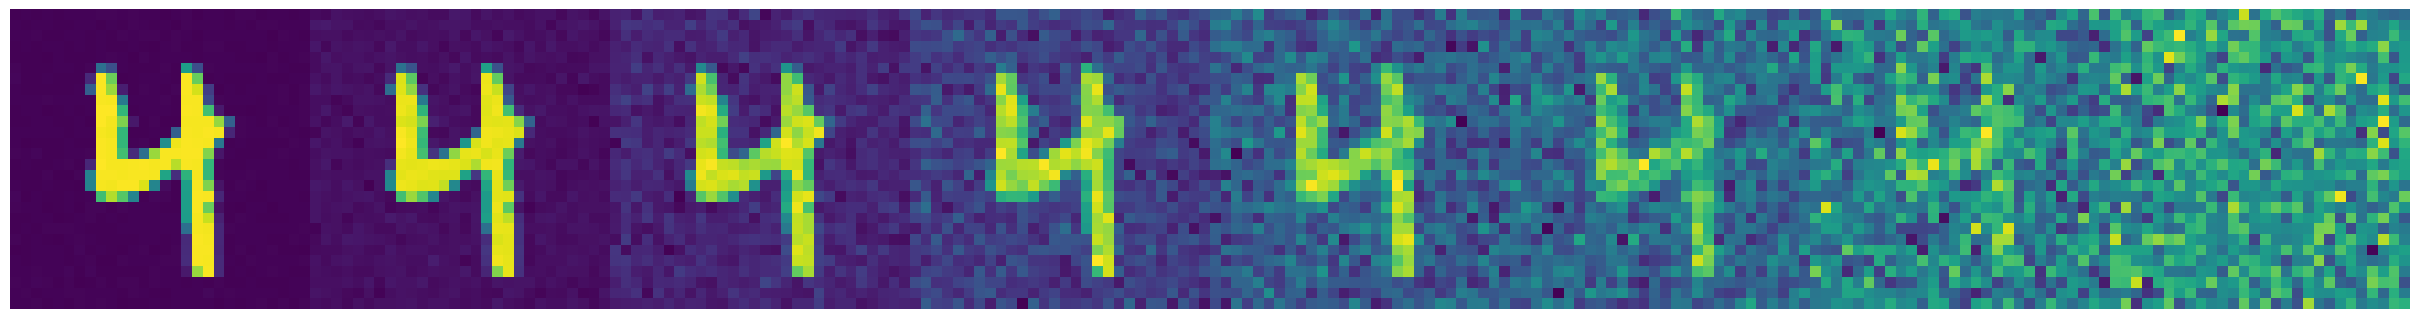

In [6]:
# Show images
diffusion = GaussianDiffusion(timesteps=1000, beta_schedule = "cosine")

images, _ = next(iter(dataloader))
x_start = images[0].unsqueeze(0)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24,3))
for t, ax in zip([0, 10, 50, 100, 200, 300, 500, 999], axes.flat):
    x_noisy = diffusion.q_sample(x_start, torch.tensor([t]))
    x_noisy = (x_noisy+1.) / 2
    ax.imshow(x_noisy[0].permute(1, 2, 0))
    ax.set_axis_off()
plt.tight_layout(w_pad=0, h_pad=0, pad=0)

### Step 4. Model & Optimizer

In [7]:
model = UNetModel(
    in_channels=in_channels,
    model_channels=model_channels,
    out_channels=out_channels,
    channel_mult=channel_mult,
    attention_resolutions=attention_resolutions).to(device)


gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Step 5. Train DDPM

In [8]:
for epoch in range(1, epochs+1):
    model.train()
    total_samples = 0
    total_loss = 0.

    pbar = tqdm(dataloader, desc = f"[Train] Epoch {epoch}/{epochs}")

    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        batch_size = data.size(0)

        optimizer.zero_grad()
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = gaussian_diffusion.train_losses(model, data, t)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += batch_size

        pbar.set_postfix(avg_loss=f"{total_loss/(batch_idx+1):.3f}")

[Train] Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:22<00:00, 11.42it/s, avg_loss=0.024]


### Step 6. Sampling

In [9]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)
imgs = (generated_images[-1] + 1.0) / 2

sampling loop time step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.61it/s]


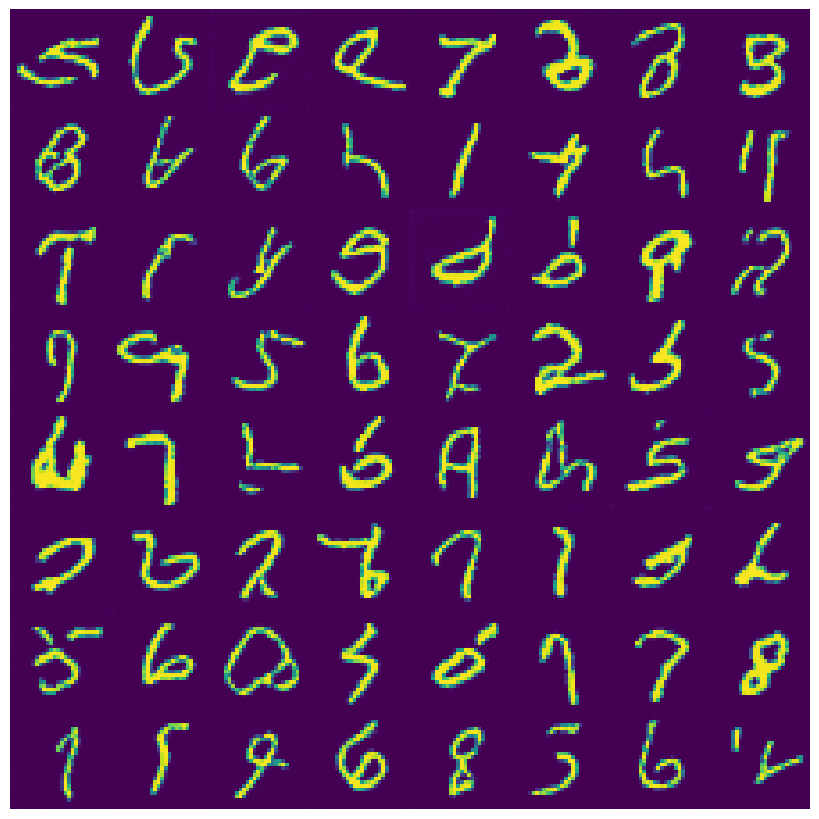

In [10]:
_, axes = plt.subplots(nrows=8, ncols=8, figsize = (8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(imgs[i], (1, 2, 0)))
    ax.set_axis_off()
plt.tight_layout(w_pad=0, h_pad=0, pad=0)

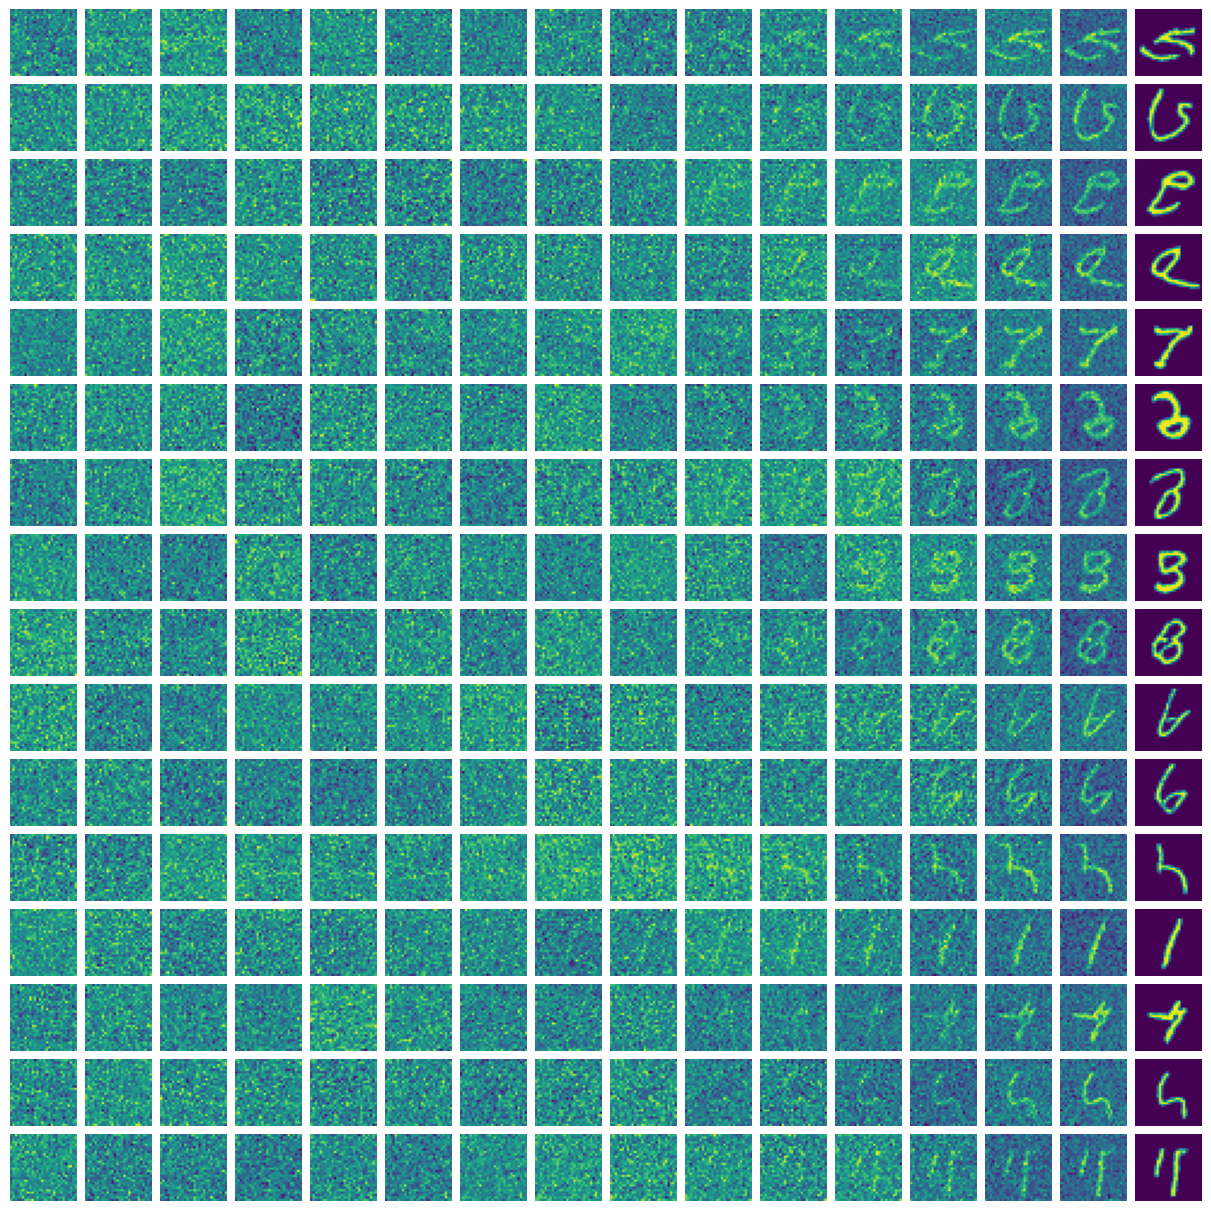

In [12]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        sample = torch.tensor((img + 1.0) / 2)
        f_ax.imshow(sample)
        f_ax.axis("off")